In [1]:
import os
import sys
# from Bio import SeqIO
import pickle
import numpy as np
import pandas as pd

# import tensorflow as tf
# import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb
# from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import math

In [2]:
##################################################################################
##### Define all experiment parameters
##################################################################################

expName = "Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL_PCA"

dataset_path = "Data"
setting = "Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL"

output_path = "Results"

datafile_extensions = ".csv"

modelNames = ["GradientBoosting"]

shuffle = False
seed = None

##################################################################################
##### Define the modelling hyperparameters
##################################################################################

n_fold = 10


In [3]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
result_output_path = os.path.join(output_path, expName)

In [4]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [5]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

error_list = []

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Encoding_Type" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if os.path.splitext(file)[-1] == datafile_extensions:
            
            try:
            
                current_dataset_variety = "_".join(file.split(".")[0].split("_")[0:(len(file.split(".")[0].split("_")) - 1)])
                encoding_type = file.split(".")[0].split("_")[-1]

                ##################################################################################
                ##### read the current file
                ##################################################################################

                input_file_full_path = os.path.join(root, file)

                ## check if input file has header
                file_obj = open(input_file_full_path, "r")
                first_line = file_obj.readline()
                file_obj.close()
                file_has_header = None
                if first_line.split(",")[0] == "nameseq" or first_line.replace("\n", "").split(",")[-1] == "label":
                    file_has_header = 0

                sequences_df = pd.read_csv(input_file_full_path, header = file_has_header)

                ##################################################################################
                ##### extract data from the current dataframe file
                ##################################################################################

                sequences_df["class"] = np.where(sequences_df[sequences_df.columns[0]].str.contains("P"), 1, 0)

                print("\n======================================================================")
                print("\nFile: "+os.path.join(root, file))
                print("Positive: "+str(sum(sequences_df["class"])))
                print("Negative: "+str(len(sequences_df) - sum(sequences_df["class"])))

                ##################################################################################
                ##### Perform PCA on entire data
                ##################################################################################

                ## create the features and labels datasets for the training
                labels = sequences_df["class"].values
                features = sequences_df.drop('nameseq', axis = 1).drop('class', axis = 1).values
                # features = features.astype(np.float)
                
                # features = StandardScaler().fit_transform(features)
                
                pca = PCA(n_components=10)
                
                features = pca.fit_transform(features)
                
                print('PCA - explained variance:', np.sum(pca.explained_variance_ratio_)*100)
                
                raise ValueError('BLEH')
                
                ##################################################################################
                ##### Generate Folds from dataset, and store to file
                ##################################################################################
                
                ## Parameters to Read/Write the k-fold dataset to file
                foldPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold))
                foldName = file.split(".")[0]+"_{}fold".format(n_fold)+".pickle"
                
                # Generate the k-fold dataset
                folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
                if(not os.path.isdir(foldPath)):
                    os.makedirs(foldPath)
                pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

#                 ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE
#                 if(os.path.isfile(os.path.join(foldPath, foldName))):
#                     folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
#                 else:
#                     ## Generate the k-fold dataset
#                     folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
#                     if(not os.path.isdir(foldPath)):
#                         os.makedirs(foldPath)
#                     pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
                    
                ##################################################################################
                ##### Execute models on folds, and evaluate
                ##################################################################################

                for modelName in modelNames:

                    ## Create and set directory to save model
                    modelPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
                    if(not os.path.isdir(modelPath)):
                        os.makedirs(modelPath)

                    ## fold counter
                    i = 0

                    for fold in folds:

                        print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")

                        # Generate model using function
#                         model = RandomForestClassifier(n_estimators=250, 
#                                                       ccp_alpha = 0.01,
#                                                       criterion='gini', 
#                                                       bootstrap=True,
#                                                       oob_score=True, 
#                                                       warm_start = False)

                        model = GradientBoostingClassifier(loss = 'deviance', 
                                                           learning_rate = 0.1, 
                                                           n_estimators = 150, 
                                                           max_depth = 10, 
                                                           validation_fraction = 0.1,
                                                           n_iter_no_change = 10, 
                                                           tol = 0.1, 
                                                           ccp_alpha = 0.0) 
                        
                        model.fit(X = fold["X_train"], y = fold["y_train"])

                        model_filename = "{}_fold{}_model.pickle".format(encoding_type, i)

                        model_file_obj = open(os.path.join(modelPath, model_filename), 'wb')
                        pickle.dump(model, model_file_obj)
                        model_file_obj.close()

                        ##################################################################################
                        ##### Prediction and metrics for TRAIN dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_train"])
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_train"], label_pred)
                        prec = precision_score(fold["y_train"],label_pred)

                        conf = confusion_matrix(fold["y_train"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                        auc = roc_auc_score(fold["y_train"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Train")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)

                        ##################################################################################
                        ##### Prediction and metrics for TEST dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_test"])
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_test"], label_pred)
                        prec = precision_score(fold["y_test"],label_pred)

                        conf = confusion_matrix(fold["y_test"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                        auc = roc_auc_score(fold["y_test"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Test")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)
                        
                        i = i+1
                        
            except Exception as error:
                error_list.append((input_file_full_path, error))
                
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(result_output_path, "_Evaluation_All_Datasets", "{}fold".format(n_fold))
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "wb"))

##################################################################################
##### Dump exceptions to a file
##################################################################################

pickle.dump(error_list,
            open(os.path.join(result_output_path, "exceptions.pickle"), "wb"))
                



File: Data\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\HS_990_ALL.csv
Positive: 495
Negative: 495
PCA - explained variance: 100.0


File: Data\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\MM_944_ALL.csv
Positive: 472
Negative: 472
PCA - explained variance: 99.99999999999999


File: Data\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\SS_628_ALL.csv
Positive: 314
Negative: 314
PCA - explained variance: 100.0


In [15]:
pca.explained_variance_ratio_

array([9.99975268e-01, 2.47319046e-05, 1.21548639e-12, 2.30294740e-13,
       1.79505137e-14, 8.43978518e-16, 5.91306350e-16, 3.45001036e-16,
       1.74669131e-16, 6.12487148e-17])

In [7]:
error_list

[('Data\\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\\HS_990_ALL.csv',
  ValueError('BLEH')),
 ('Data\\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\\MM_944_ALL.csv',
  ValueError('BLEH')),
 ('Data\\Psi_Site_Chen_MathFeature_Latest_5_0_10_5_1_ALL\\SS_628_ALL.csv',
  ValueError('BLEH'))]

In [19]:
features[:,0]

(628,)

In [20]:
features[:,0]

array([ 7.02417374e+09, -2.66845886e+09,  6.80590193e+10, -4.50645161e+10,
        3.19187629e+10,  3.70946370e+10,  5.75316625e+10, -4.04779968e+10,
        2.69769153e+10,  4.21827825e+10,  1.68037179e+10, -9.41736731e+10,
       -8.10724149e+10, -6.78426145e+10,  1.21701198e+10,  3.70966916e+10,
        5.23277983e+10, -2.69500815e+09,  7.84025420e+10, -3.13893336e+10,
       -7.47326529e+09, -3.10864222e+10, -1.70279977e+10, -7.41367928e+09,
       -6.32535699e+10, -2.58353187e+09, -2.16390172e+10,  7.16675153e+09,
        7.13854969e+09,  6.27957342e+10, -7.61322033e+09, -7.30434261e+09,
        3.69881844e+10, -8.55799332e+10,  7.05293799e+09,  7.25181983e+09,
       -2.64739249e+10, -5.87200225e+10, -7.67235249e+10,  1.20549252e+10,
        1.71729631e+10, -1.70839237e+10, -2.17793039e+10, -2.16673303e+10,
        4.70643169e+10, -4.52810326e+10, -9.84194206e+10,  1.69140669e+10,
        2.18873760e+10,  1.20842814e+10, -8.54731642e+10, -1.24457175e+10,
        7.16643816e+09, -

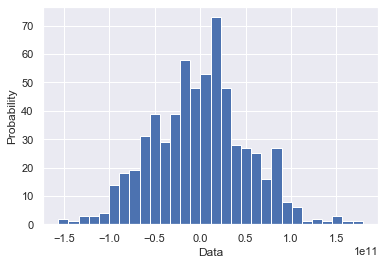

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(features[:,0], density=False, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

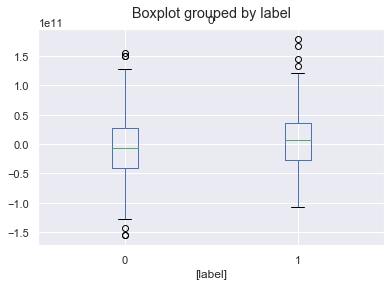

In [35]:
df = pd.DataFrame(features[:,0])
df['label'] = labels

df.boxplot(by='label')

## Visualization of Evaluation

In [8]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [9]:
# ##################################################################################
# ##### Parameters used only in this section
# ##################################################################################

# n_fold = 10

# expName = "MathFeature_setting1_kgap_fickett"
# outPath = "Generated"
# setting = "Setting1"
# output_path = "Results"

# ExtraTreeForest, RandomForest, XGBoost
# modelNames = ["XGBoost"]

In [10]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(result_output_path, "_Evaluation_All_Datasets", "{}fold".format(n_fold))

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [11]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Encoding_Type",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

Eval_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Train'])]
Eval_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Test'])]

datasets = np.unique(evaluations_df_grouped.index.get_level_values(0))

In [12]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ", list(evaluations_df_grouped.columns))

Metrics Available :  ['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [13]:
metric_to_plot = "Accuracy"
# dataset_to_print = "HS_990"

In [14]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

# df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
df = evaluations_df_grouped.reset_index(level=['Dataset', 'Train_Test'])

# Some boilerplate to initialise things
sns.set()
plt.figure(figsize=(20,8))

# This is where the actual plot gets made
ax = sns.barplot(data=df, x="Dataset", y=metric_to_plot, hue="Train_Test")

# Customise some display properties
ax.set_title(modelNames[0])
ax.grid(color='#cccccc')
ax.set_ylabel(metric_to_plot)
ax.set_xlabel("Dataset")
ax.set_xticklabels(df["Dataset"].unique().astype(str), rotation='vertical')

for p in ax.patches:
    ax.annotate(format(p.get_height()*100, '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size=15,
                xytext = (0, -12), 
                textcoords = 'offset points')

##############################

# Ask Matplotlib to show it
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1440x576 with 0 Axes>

In [ ]:
# ##################################################################################
# ##### Visualize with a multiple Bar chart
# ##################################################################################

# df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
# df = df.reset_index(level=['Encoding_Type', 'Train_Test'])

# # Some boilerplate to initialise things
# sns.set()
# plt.figure(figsize=(20,8))

# # This is where the actual plot gets made
# ax = sns.barplot(data=df, x="Encoding_Type", y=metric_to_plot, hue="Train_Test")

# # Customise some display properties
# ax.set_title(dataset_to_print+" - "+modelNames[0])
# ax.grid(color='#cccccc')
# ax.set_ylabel(metric_to_plot)
# ax.set_xlabel("Encoding_Type")
# ax.set_xticklabels(df["Encoding_Type"].unique().astype(str), rotation='vertical')

# # for p in ax.patches:
# #     ax.annotate(format(p.get_height()*100, '.4f'),
# #                 (p.get_x() + p.get_width() / 2., p.get_height()), 
# #                 ha = 'center', va = 'center', 
# #                 size=15,
# #                 xytext = (0, -12), 
# #                 textcoords = 'offset points')

# ##############################

# # Ask Matplotlib to show it
# plt.show()

### Store all metrics' plots to file

In [ ]:
# ##################################################################################
# ##### Iteratively generate comparison plot using every metric
# ##################################################################################

# for metric_to_plot in list(evaluations_df_grouped.columns):
#     for dataset_to_print in datasets:
    
#         df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
#         df = df.reset_index(level=['Encoding_Type', 'Train_Test'])

#         # Some boilerplate to initialise things
#         sns.set()
#         plt.figure(figsize=(20,8))

#         # This is where the actual plot gets made
#         ax = sns.barplot(data=df, x="Encoding_Type", y=metric_to_plot, hue="Train_Test")

#         # Customise some display properties
#         ax.set_title(dataset_to_print+" - "+modelNames[0])
#         ax.grid(color='#cccccc')
#         ax.set_ylabel(metric_to_plot)
#         ax.set_xlabel("Encoding_Type")
#         ax.set_xticklabels(df["Encoding_Type"].unique().astype(str), rotation='vertical')
        
# #         for p in ax.patches:
# #             ax.annotate(format(p.get_height()*100, '.4f'),
# #                         (p.get_x() + p.get_width() / 2., p.get_height()), 
# #                         ha = 'center', va = 'center', 
# #                         size=15,
# #                         xytext = (0, -12), 
# #                         textcoords = 'offset points')
        
#         plt.savefig(os.path.join(evalPath, "{}_{}_{}_Comparison".format(metric_to_plot, dataset_to_print, modelNames[0])))
#         plt.close()
    